In [1]:
import sys, os
import pandas as pd
import numpy as np
import seaborn as sns
profit_path = os.path.abspath(os.path.join('..'))
sys.path.append(profit_path)
from profit import NaivePortfolio, Strategy, Future, Backtest, Perfomance

%load_ext autoreload
%autoreload 2
%pylab inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, rc=None)

Populating the interactive namespace from numpy and matplotlib


In [2]:
store = pd.HDFStore('tests/data.h5', complevel=5, complib='blosc')
store

<class 'pandas.io.pytables.HDFStore'>
File path: tests/data.h5
/rih5_sec              frame_table  (typ->appendable,nrows->2920322,ncols->3,indexers->[index]) 
/rih5_ticks            frame_table  (typ->appendable,nrows->18608303,ncols->4,indexers->[index])

<b>RIH5, секундные данные</b>

In [3]:
data = store.select('rih5_sec')
data.head(5) 

,price,timestamp,ticker
0,70500,2014-12-16 10:00:00,rih5
1,72000,2014-12-16 10:00:01,rih5
2,71390,2014-12-16 10:00:02,rih5
3,72830,2014-12-16 10:00:03,rih5
4,72350,2014-12-16 10:00:04,rih5


<b>Стратегия</b>

In [5]:
class SMACross(Strategy):
    """
    Простая стратегия пересечения скользящих средних
    """

    def __init__(self, w=[50,100]):
        """
        Инициализация параметров
        w - размер окон
        """
        self.period_type = 'intraday'
        self.w = w

    def generate_signals(self, data):

        ms = pd.rolling_mean(data.price, self.w[0]) # короткая скользящая
        ml = pd.rolling_mean(data.price, self.w[1]) # длинная скользящая
        signals = pd.Series(index=data.index)       # массив сигналов
        signals[(ms > ml) & (ms.shift() < ml.shift())] = 1  # Покупка: до пересечения малая меньше, после больше
        signals[(ms < ml) & (ms.shift() > ml.shift())] = -1 # Продажа: наоборот
        signals.fillna(0, inplace=True) # Остальные заполняем нулями
        return signals

<b>Инициализация параметров</b>

In [6]:
instrs = [Future('rih5', slippage=2)] # Проскальзывание 2 пункта фьюча
strategy = SMACross([600,1200]) # Окна 10 и 20 минут
port = NaivePortfolio(order_size=1) # Постоянный размер ордера, нет риск-менеджмента
bt = Backtest(instrs, data, strategy, port)

<b>Запуск</b>

In [7]:
bt.run()

Backtesting begin at 2015-05-04 04:04:26.592285
Initializing data...Done.
Generating signals...Done.
Generating orders...Done.
Simulating market execution...Done.
Calculating positions...Done.
Backtesting done in 0h 0min 17sec for 2920322 data rows.



<b>Статистика</b>

In [9]:
perf = Perfomance(bt.data)

In [10]:
perf.summary_total

,OVERALL,MIN,MAX,AVG
Days traded,59,2014-12-16,2015-03-16,-
Trades,2659,30.0,57.0,45.0677966102
Gain,217980.0,740.0,16470.0,3694.57627119
Loss,-209060.0,-900.0,-10500.0,-3543.38983051
PNL,8920.0,-6110.0,10640.0,151.186440678
Most trade PNL,-,-7060.0,5360.0,0.00305445769336
Winrate,0.000180802,6.02397542218e-05,0.000281118853035,0.000180273002151
Payoff,1.510683,0.32240880139,3.56549707602,1.6468816411
Sharpe,0.113984537233,-4.29821523247,3.0900295338,-0.0999966628649
Max drowdown,16880.0,380.0,7060.0,2208.98305085


In [11]:
perf.summary

,gain,loss,maxdd,payoff,pf,pnl,sharpe,trades,winrate
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,3694.576271,-3543.389831,2208.983051,1.646882,1.222626,151.186441,-0.099997,45.067797,0.000180
std,2639.168705,1961.789832,1625.050339,0.802750,0.780501,2978.862364,2.164063,5.384731,0.000048
min,740.000000,-10500.000000,380.000000,0.322409,0.195323,-6110.000000,-4.298215,30.000000,0.000060
25%,2165.000000,-4000.000000,1160.000000,1.065711,0.544867,-1770.000000,-2.030887,42.500000,0.000141
50%,3220.000000,-3080.000000,1620.000000,1.502573,1.228288,560.000000,0.741367,46.000000,0.000181
75%,4605.000000,-2315.000000,2745.000000,2.060911,1.633297,1520.000000,1.615301,48.000000,0.000221
max,16470.000000,-900.000000,7060.000000,3.565497,3.759091,10640.000000,3.090030,57.000000,0.000281


In [12]:
perf.daily_stat

,gain,loss,maxdd,payoff,pf,pnl,sharpe,trades,winrate
2014-12-16,16470,-5830,3010,3.390051,2.825043,10640,2.775048,44,0.000201
2014-12-17,11440,-6480,1490,2.868827,1.765432,4960,1.634948,44,0.000161
2014-12-18,3860,-8210,6610,1.074648,0.470158,-4350,-2.515509,48,0.000141
2014-12-19,2210,-6830,5010,0.388287,0.323572,-4620,-2.514099,44,0.000201
2014-12-22,4490,-2380,1220,2.096172,1.886555,2110,2.298034,38,0.000181
2014-12-23,4260,-3080,1480,2.074675,1.383117,1180,0.979802,30,0.000120
2014-12-24,2220,-3900,2700,0.910769,0.569231,-1680,-2.119166,53,0.000201
2014-12-25,2450,-2030,1190,1.327586,1.206897,420,0.602189,44,0.000201
2014-12-26,5190,-3180,1620,2.856132,1.632075,2010,1.421424,46,0.000161
2014-12-29,8270,-2200,1530,2.733884,3.759091,6070,2.831152,38,0.000221


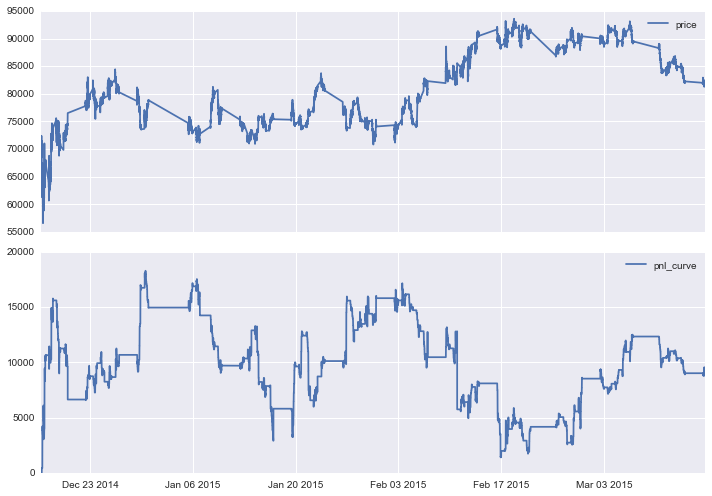

In [13]:
perf.show_day('all')

2014-12-16


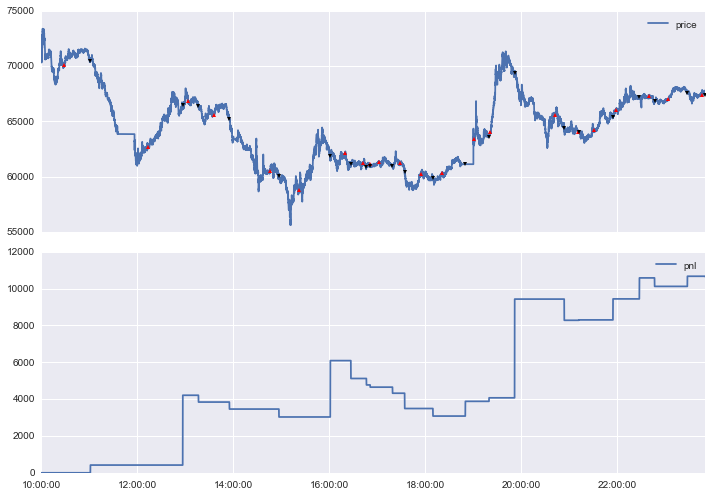

In [14]:
perf.show_day(('best', 'pnl'))

2015-02-16


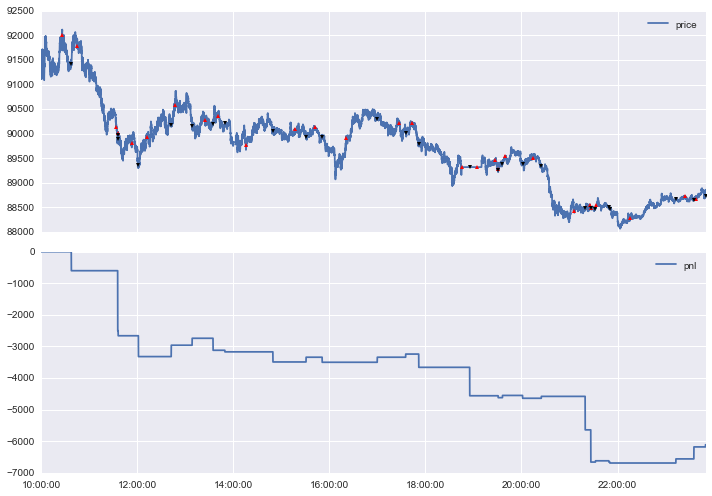

In [15]:
perf.show_day(('worst', 'pnl'))

2015-01-12


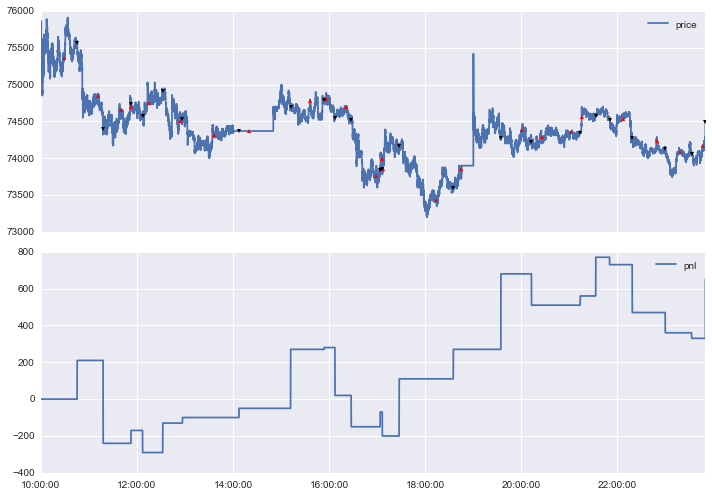

In [16]:
perf.show_day(('best', 'winrate'))

2015-01-08


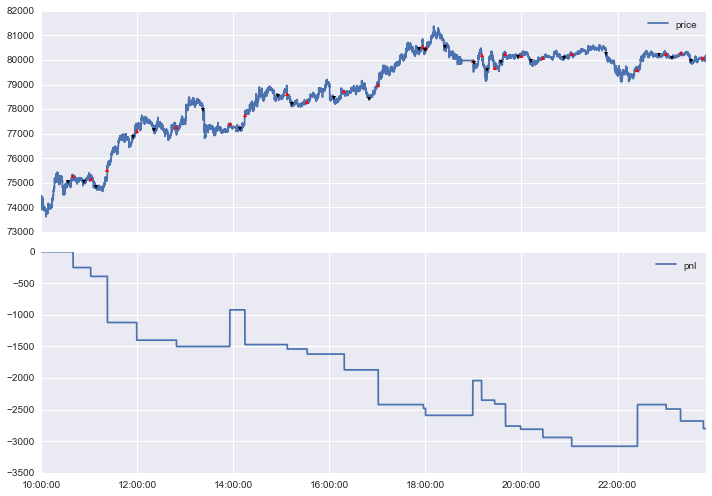

In [17]:
perf.show_day(('worst', 'winrate'))

2015-01-26


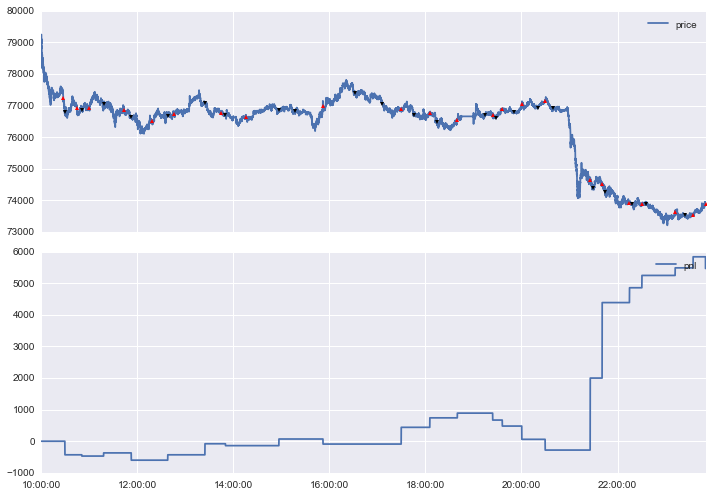

In [18]:
perf.show_day(('best', 'sharpe'))

2015-02-16


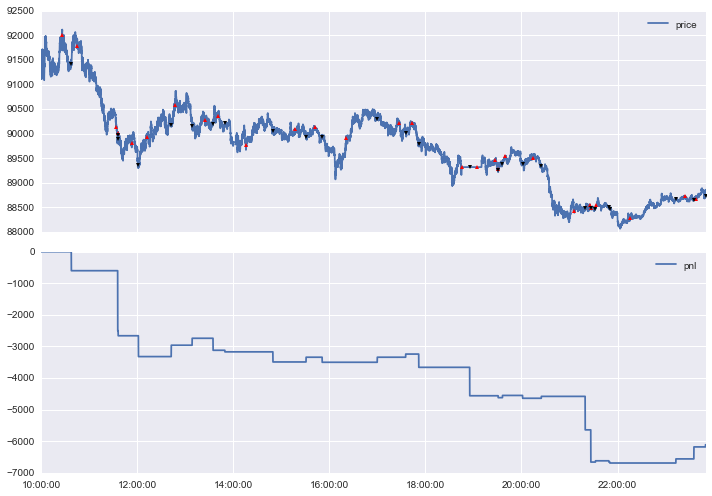

In [19]:
perf.show_day(('worst', 'sharpe'))